* In 2.2 we looked at location in terms of latitude and longitude to predict Apartment price
* This time we would look at location in terms of Neighbourhood to predict Apartment price
* **OBJECTIVES**
    * Build a model to predict apartment price based on **neighbourhood**
    * Encode **categorical data** to train a linear model
    * Battle **overfitting** using **regularisation**
    
**MACHINE LEARNING WORKFLOW**
1. **Preparing Data**
    * Importing data: `wrangle` function and `for` loop
    * Exploring data: extract neighbourhood information from string
    * Splitting data
2. **Building the Model**
    * Baselining
    * Iterating: `One-Hot Ecoding` for Categorical data
    * Evaluating: Overfitting 
3. **Communicating Results**
    * Curse of Dimensionality
    * Regularisation: Ridge Regression Model
    * Bar Charts for Coefficients

In [1]:
# importing libraries

from glob import glob # To search for files which follow a certain pattern

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from category_encoders import OneHotEncoder # scikit has its own OneHotEncoder as well
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

# 1. Preparing Data
## 1.1 Importing Data

In [2]:
# Using the wrangle function from 2.2 file

def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    

    return df

#### To import multiple similarly names files at the same time, glob library can be used. Just need to put asterisk *

In [3]:
files = glob('buenos-aires-real-estate-*.csv') 
# * implies a wildcard, any file with title matching before * would be pulled. Can work for any file format
files

['buenos-aires-real-estate-1.csv',
 'buenos-aires-real-estate-2.csv',
 'buenos-aires-real-estate-3.csv',
 'buenos-aires-real-estate-4.csv',
 'buenos-aires-real-estate-5.csv']

**Pulling data from files above into DataFrames using a `for` loop**

In [4]:
frames = [] # An empty list which is to be filled with dataframes 
for file in files:
    df = wrangle(file)
    frames.append(df)

**Concatenating DataFrames in frames list**

In [5]:
df = pd.concat(frames, ignore_index=True)
df.shape

(6582, 17)

## 1.2 Exploring Data
We want neighbourhood information in such a way that makes it easier to predict Apartment priices

In [6]:
df.head()

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
0,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693
1,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115
2,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957
3,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382
4,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511


In the column `place_with_parent_names`, we have country, province and neighbourhood information. We only need neighbourhood information

In [7]:
# Splitting string to get neighbourhood information
df['place_with_parent_names'].str.split('|', expand = True)[3].head()

0       Chacarita
1      Villa Luro
2       Caballito
3    Constitución
4            Once
Name: 3, dtype: object

In [8]:
# Modifying wrangle function

def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Extracting neighbourhood information
    df['neighbourhood'] = df['place_with_parent_names'].str.split('|', expand = True)[3]
    df.drop(columns = 'place_with_parent_names', inplace = True)

    return df

In [9]:
# re-running wrnagle function to get updated data
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)
df = pd.concat(frames, ignore_index=True)
df.head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighbourhood
0,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
1,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
2,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
3,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
4,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


## 1.3 Splitting Data

In [10]:
target = 'price_aprox_usd'
features = ['neighbourhood']
y_train = df[target]
X_train = df[features]

# 2. Building Model
## 2.1 Baselining

In [11]:
y_mean = round(y_train.mean(), 2)
y_pred_baseline = [y_mean] * len(y_train)
print('Mean Apt. Price:', y_mean)
print('Baseline MAE:', round(mean_absolute_error(y_train, y_pred_baseline), 2))

Mean Apt. Price: 132383.84
Baseline MAE: 44860.11


## 2.2 Iterating
#### OneHotEncoding neighbourhood data
    * At this stage we can not use a Linear Regression model for neighbourhood
    * It is because the neighbourhood values are a string and the model requires float values
    * So neighbourhood information needs to be **encoded** into a numerical form
    * OneHotEncoder (OHE) from Category Encoders library can be used for this purpose
        * OHE goes through the column to be encoded and finds the unique values in the column
        * Now these values can be represented in a binary way (sort of like on/off switch)
    * Normally OHE is done inside the pipeline

In [12]:
X_train.head()

,neighbourhood
0,Chacarita
1,Villa Luro
2,Caballito
3,Constitución
4,Once


In [13]:
# Instantiating OneHotEncoder Transformer
ohe = OneHotEncoder(use_cat_names = True)
# Fitting training data to ohe
ohe.fit(X_train)
# Transforming training data
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighbourhood_Chacarita,neighbourhood_Villa Luro,neighbourhood_Caballito,neighbourhood_Constitución,neighbourhood_Once,neighbourhood_Almagro,neighbourhood_Palermo,neighbourhood_Flores,neighbourhood_Belgrano,neighbourhood_Liniers,...,neighbourhood_Puerto Madero,neighbourhood_Agronomía,neighbourhood_Monte Castro,neighbourhood_Tribunales,neighbourhood_Villa Santa Rita,neighbourhood_Velez Sarsfield,neighbourhood_Villa Soldati,neighbourhood_Villa Real,neighbourhood_Pompeya,neighbourhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As can be seen from above, the neighbourhood string has been encoded for all observations in training data

**Pipelining**

In [14]:
# Instantiating model with Transformer and LinearRegression Predictor components
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LinearRegression()
)

# Fitting model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighbourhood'], use_cat_names=True)),
                ('linearregression', LinearRegression())])

## 2.3 Evaluating

In [15]:
# Checking how the model performed on training data
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print('Training MAE:', round(mae_training, 2))

Training MAE: 39339.72


In [16]:
X_test = pd.read_csv("buenos-aires-test-features.csv")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    249409.478261
1    161530.079797
2     98036.930192
3    110675.394444
4    127796.268745
dtype: float64

# 3. Communicating Results
The mean absolute error for our  model on test data is in billions. The reason for that is there are too many variables which are the neighbourhoods. This is the curse of dimensionality. 

#### Extracting intercept and coefficient

In [17]:
intercept = model.named_steps['linearregression'].intercept_
coefficients = model.named_steps['linearregression'].coef_
print('coefficients len:', len(coefficients))
print(coefficients[:5])

coefficients len: 57
[ -1910.75043614   1046.27470672  10324.25164214 -41623.85243614
  -2217.13905402]


#### Extracting feature names from `OneHotEncoder`

In [18]:
feature_names = model.named_steps['onehotencoder'].get_feature_names()
print('features len:', len(feature_names))
print(feature_names[:5])

features len: 57
['neighbourhood_Chacarita', 'neighbourhood_Villa Luro', 'neighbourhood_Caballito', 'neighbourhood_Constitución', 'neighbourhood_Once']


#### Putting coefficients and feature names together in a series

In [19]:
feat_imp = pd.Series(coefficients, index = feature_names)
feat_imp.head()

neighbourhood_Chacarita       -1910.750436
neighbourhood_Villa Luro       1046.274707
neighbourhood_Caballito       10324.251642
neighbourhood_Constitución   -41623.852436
neighbourhood_Once            -2217.139054
dtype: float64

### Curse of dimensionality and Ridge
* The more dimensions are added, data points get further and further apart. When a linear model tries to fit these points, it gets wacky and starts shooting up all over the space. It begins to favour certain data points and is unable to generalise for the data the model has not seen before
* One way to overcome this Overfitting is by **Regularisation techniques**. It brings the model to normal. 
    * There are many techniques, and for Linear Regression, Ridge Regression technique comes in handy
    * A Ridge Regression tries to get as close to data points without making the coefficients extreme

In [25]:
# trying with Ridge regression model again
model2 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)
model2.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighbourhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [26]:
# Checking how the model performed on training data
y_pred_training = model2.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print('Training MAE:', round(mae_training, 2))

Training MAE: 39350.22


In [28]:
# Testing model on test data
X_test = pd.read_csv("buenos-aires-test-features.csv")[features]
y_pred_test = pd.Series(model2.predict(X_test)).round(2)
y_pred_test.head()

0    246624.69
1    161355.97
2     98232.05
3    110846.03
4    127777.54
dtype: float64

In [33]:
# Extracting intercept and coefficient
intercept2 = model2.named_steps['ridge'].intercept_
coefficients2 = model2.named_steps['ridge'].coef_
print('coefficients2 len:', len(coefficients2))
print(coefficients2[:5])

coefficients2 len: 57
[-2.89895934e+03 -6.29555347e+00  9.25289088e+03 -4.17487330e+04
 -3.23037446e+03]


In [31]:
# Extracting feature names
feature_names = model2.named_steps['onehotencoder'].get_feature_names()
print('features len:', len(feature_names))
print(feature_names[:5])

features len: 57
['neighbourhood_Chacarita', 'neighbourhood_Villa Luro', 'neighbourhood_Caballito', 'neighbourhood_Constitución', 'neighbourhood_Once']


In [35]:
# Putting features and coefficients in a series
feat_imp2 = pd.Series(coefficients2, index = feature_names)
feat_imp2.head()

neighbourhood_Chacarita       -2898.959335
neighbourhood_Villa Luro         -6.295553
neighbourhood_Caballito        9252.890876
neighbourhood_Constitución   -41748.733031
neighbourhood_Once            -3230.374461
dtype: float64

In [37]:
# Printing the linear equation for model
print(f'price = {intercept2.round(2)}')
for f, c in feat_imp2.items():
    print(f'+ ({round(c, 2)} * {f})')

price = 118524.65
+ (-2898.96 * neighbourhood_Chacarita)
+ (-6.3 * neighbourhood_Villa Luro)
+ (9252.89 * neighbourhood_Caballito)
+ (-41748.73 * neighbourhood_Constitución)
+ (-3230.37 * neighbourhood_Once)
+ (2903.34 * neighbourhood_Almagro)
+ (45934.41 * neighbourhood_Palermo)
+ (-8662.28 * neighbourhood_Flores)
+ (46954.21 * neighbourhood_Belgrano)
+ (-13729.1 * neighbourhood_Liniers)
+ (6277.05 * neighbourhood_Villa Crespo)
+ (-10678.63 * neighbourhood_San Cristobal)
+ (-7974.66 * neighbourhood_Congreso)
+ (14701.16 * neighbourhood_Saavedra)
+ (-11172.55 * neighbourhood_Balvanera)
+ (-29585.61 * neighbourhood_Parque Avellaneda)
+ (72740.78 * neighbourhood_Recoleta)
+ (5638.47 * neighbourhood_San Telmo)
+ (42831.32 * neighbourhood_Nuñez)
+ (55590.93 * neighbourhood_Barrio Norte)
+ (-6323.68 * neighbourhood_Parque Centenario)
+ (4330.55 * neighbourhood_Abasto)
+ (-7905.29 * neighbourhood_Centro / Microcentro)
+ (-19370.74 * neighbourhood_)
+ (-7108.23 * neighbourhood_Paternal)
+ (-2

**The model makes more sense now that being in a certain neighbourhood increases or decreases the apartment price by a few thousand dollars**

### Visualising using a BarChart

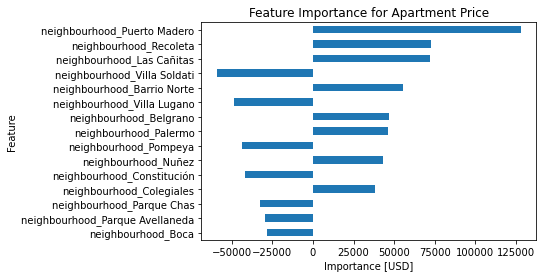

In [38]:
# Sorting absolute values from smallest to largest. taking last 15 values (the most influential ones)
feat_imp2.sort_values(key = abs).tail(15).plot(kind = 'barh') # This chart is being built on  pandas
plt.xlabel('Importance [USD]')# Using matplotlib for axis labels
plt.ylabel('Feature')
plt.title('Feature Importance for Apartment Price');

**It makes sense that Puerto Madero is one of the poshest neighbourhood in Buenos Aires which is reflected in the increased price by almost 125_000 USD. Villa Soldati is one of the more deprived neighbourhoods and it is reflected in the penalty of over 50_000 USD**